<img src="img/normalizing_flow.png" width="800">

<span style="font-size:4em;"> Normalizing flows </span>

**Aurélien Nioche**

Aalto University

In [1]:
import math
import numpy as np
import scipy

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.distributions as dist

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%config InlineBackend.figure_format='retina'
sns.set()

# What are normalizing flows?

## In 7 words
 
<span style="color:blue">**A family of methods for constructing flexible distributions.**</span>

## How does it work?

[Note: This part is adapted from https://pyro.ai/examples/normalizing_flows_i.html]


### Basic idea

> The basic idea is that a simple source of noise, for example a variable with a standard normal distribution, $X\sim\mathcal{N}(0,1)$, is passed through a bijective (i.e. invertible) function, $f(\cdot)$ to produce a more complex transformed variable $Z=f(X)$.

### A little bit more

Let's assume $X$ and $Z$ two random variables such that $Z=f(X)$. How does the density of $Z$ relate to the density of $X$? 


Using the [integration by substitution](https://en.wikipedia.org/wiki/Integration_by_substitution): 


$$ 
\begin{align}
P(Z\in S) &=\int _{S}p_{Z}(z)\,dz\\
& =\int _{f ^{-1}(S)}p_{X}(x)\,dx \\
&= \int _{S}p_{X}(f ^{-1}(z))\left|{\frac {df ^{-1}}{dz}}\right|\,dz\\
\end{align}
$$

So:

$$
\begin{align}
     \ln p_Z(z) &= \ln p_X(f ^{-1}(z)) +\ln \left|\frac{df ^{-1}}{dz}\right| \\
                &= \ln p_X(f ^{-1}(z)) +\ln \left|\frac{df}{dz}\right|^{-1} \\
                &= \ln p_X(f ^{-1}(z)) - \ln \left|\frac{df}{dz}\right| \\
                &= \ln p_X(x) - \ln \left|\frac{df}{dz}\right|
\end{align}
$$

Note that $\ln p_Z(z)$ can simply be seen as:
$$ \ln p_Z(z) = \ln p_X(x) + \text{CORRECTION TERM}$$

Now, assume that we have $K$ transforms $f_1, f_2,\ldots,f_K$, and that $Z=(f_1\circ f_2\circ\cdots\circ f_K)(X)$. Then:

$$
\begin{align}
     \ln p_Z(z) &= \ln p_X(x) - \sum^K_{k=1}\ln \left\vert\frac{df_k}{dz_k}\right\vert
\end{align}
$$

where $z_k = f_k \circ f_{k-1} \circ \ldots \circ f_1(x)$.

Now, assume that we are dealing with multivariate distributions:

$$
\log(p_Y( \mathbf y)) = \ln p_X(\mathbf x) - \sum^{K}_{k=1}\ln \det \left\vert\frac{\partial f_k}{\partial \mathbf z_k}\right\vert 
$$

The main challenge is in:
* designing parametrizable multivariate bijections that have closed form expressions for both $f$ and $f^{-1}$, 
* ... and have a tractable Jacobian whose calculation scales with $O(D)$ rather than $O(D^3)$, 
* ... and can express a flexible class of functions.

# What for?

## Learn a target probability distribution

### Choose a target distribution

We will take as example:

$$U(\mathbf Z) = 0.5\left(\frac{\vert \vert \mathbf Z \vert \vert - 4}{0.4}\right)^2 - \ln \left[e^{-\frac{1}{2}\left(\frac{\mathbf Z_1 - 2}{0.8}\right)^2} + e^{-\frac{1}{2}\left(\frac{\mathbf Z_1 + 2}{0.8}\right)^2} \right] $$

In [93]:
def p_z(z):

    z1, z2 = torch.chunk(z, chunks=2, dim=1)
    norm = torch.sqrt(z1 ** 2 + z2 ** 2)

    exp1 = torch.exp(-0.5 * ((z1 - 2) / 0.8) ** 2)
    exp2 = torch.exp(-0.5 * ((z1 + 2) / 0.8) ** 2)
    u = 0.5 * ((norm - 4) / 0.4) ** 2 - torch.log(exp1 + exp2)

    return torch.exp(-u)

In [5]:
def plot_density(density, x_lims=(-7, 7), y_lims=(-7, 7)):

    x1 = np.linspace(*x_lims, 300)
    x2 = np.linspace(*y_lims, 300)
    x1, x2 = np.meshgrid(x1, x2)
    shape = x1.shape
    x1_r = x1.ravel()
    x2_r = x2.ravel()

    z = np.c_[x1_r, x2_r]
    z = torch.from_numpy(z)

    density_values = density(z).data.numpy().reshape(shape)

    fig, ax = plt.subplots(figsize=(7, 7))
    ax.contourf(x1, x2, density_values, cmap='viridis')
    ax.set_title("True density")
    plt.xlabel('$z_1$')
    plt.ylabel('$z_2$')
    plt.show()

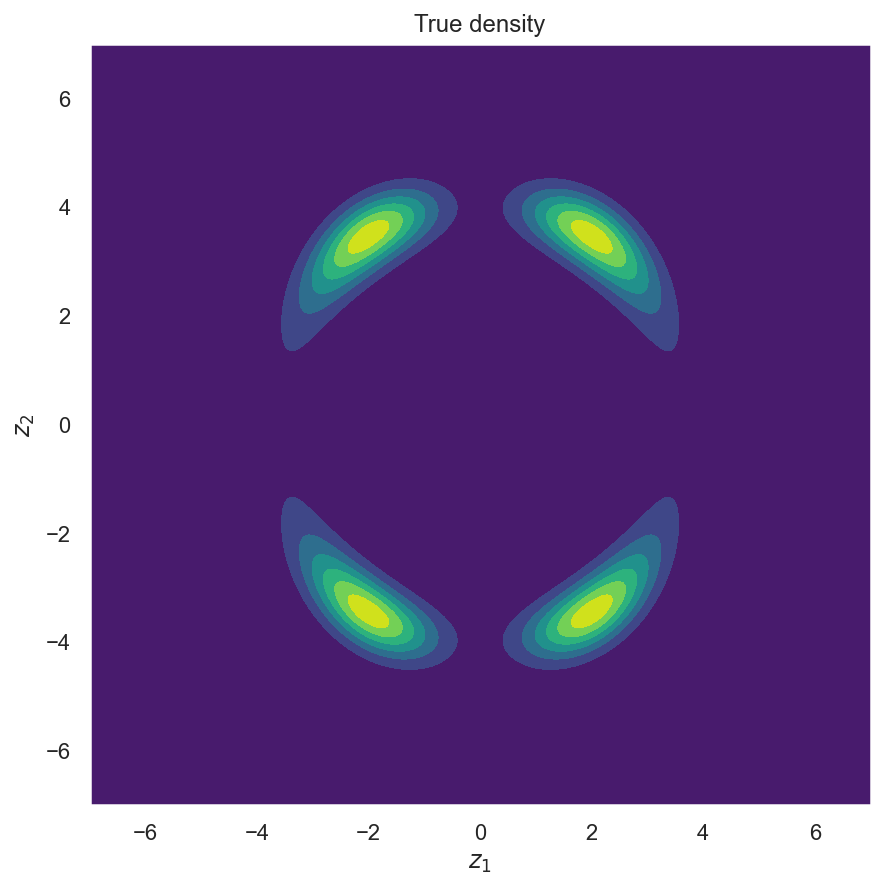

In [6]:
plot_density(p_z)

### Define the objective: Maximizing the lower bound

**[Variational infence](https://en.wikipedia.org/wiki/Variational_Bayesian_methods): Maximizing the lower bound!**

$$
\begin{align}
\log p_\theta(x) &= \log \int p_\theta (x|z)p(z)dz = \log \int \frac{q_\phi (z|x)}{q_\phi (z|x)} p_\theta (x|z)p(z)dz \\
&\geq - \mathbb D_{KL}[q_\psi(z|x) \mid \mid p(z)]+ \mathbb E_q[ \log p_\theta(x|z)] = - \mathcal F(x)
\end{align}
$$
where $\mathcal F$ is the free energy bound (= negative evidence lower bound; ELBO).

<img src="img/kl.png" width="400">

<img src="img/lower_bound.png" width="400">

Image from [Bishop, 2006](https://www.microsoft.com/en-us/research/people/cmbishop/prml-book/)

In the case of normalizing flows, the free energy bound can be expressed as:

$$ 
\begin{align}
\mathcal F(x) &= \mathbb E_{q_{\phi}}(z|x) \left[ \ln q_\phi(z|x) - \ln p(x, z) \right] \\
&= \mathbb E_{q_0(z_0)} \left[ \ln q_K (z_K ) - \ln p(x, z_K) \right] \\
&= \mathbb E_{q_0 (z_0)} \left[\ln q_0 (z_0 ) \right] - \mathbb E_{q_0 (z_0)} \left[  \sum^{K}_{k=1}\ln \det \left\vert\frac{\partial f_k}{\partial \mathbf z_k}\right\vert   \right] - \mathbb E_{q_0 (z_0)} [\ln p(x, z_K )] \\
\end{align}
$$

**Generic algorithm**

Parameters: $\phi$ (variational), $\theta$ (generative)

**while** not converged **do**
1. $x \leftarrow$ {Get minibatch}
2. $z_0 \sim q_0(\cdot \mid x)$
3. $z_K \leftarrow f_K \circ  f_{K−1} \circ \dots  \circ f_1(z_0)$
4. $\mathcal F(x) \approx \mathcal F(x, z_k)$
5. $\Delta_\theta \propto - \nabla_\theta \mathcal F(x)$
6. $\Delta_\phi \propto - \nabla_\phi \mathcal F(x)$

**end while**

Note: depending of cases of applications, slight variations are possible (for instance, in the next example, we do not take data from a minibatch, but generate directly from $q_0$ a sample, and for computing the free energy, we evaluate $\ln p(z_k)$ considering the 'true' probability density function - instead of evaluating the joint probability distribution $\ln p(x, z_K )$).

*From Danilo Jimenez Rezende, Shakir Mohamed. [*Variational Inference with Normalizing Flows*](http://proceedings.mlr.press/v37/rezende15.pdf). ICML 2015.*

### Choose one type of normalizing flow

 We will use **planar flows**, what means transformations of the following shape:
        
$$ f(z) = \mathbf z + \mathbf u h(\mathbf w^\top \mathbf z + b), $$
where free parameters are $ {w \in \mathbb R^D,u \in \mathbb R^D,b \in \mathbb R}$, and $h$ is a smooth element-wise non-linearity, with derivative $h'(\cdot)$.

We can compute the logdet-Jacobian term in $O(D)$ time (using the matrix determinant lemma):
$$\psi(z) = h'(\mathbf w^\top \mathbf z + b) \mathbf w$$
$$\det \left\vert \frac{\partial f}{\partial \mathbf z} \right\vert=\vert\det(\mathbf I+\mathbf u\psi(z) )|=|1+ \mathbf u^\top \psi(z)|$$ 


In [7]:
class PlanarBasedNormalizingFlow(nn.Module):
    """
    Adapted from https://github.com/ex4sperans/variational-inference-with-normalizing-flows

    [Rezende and Mohamed, 2015]

    """
    def __init__(self, dim, flow_length):
        super().__init__()

        self.transforms = nn.Sequential(*(
            PlanarFlow(dim) for _ in range(flow_length)
        ))

        self.log_jacobians = nn.Sequential(*(
            PlanarFlowLogDetJacobian(t) for t in self.transforms
        ))
        
        self.dim = dim
        self.flow_length = flow_length
        
        self.mu = nn.Parameter(torch.zeros(dim).uniform_(-0.01, 0.01))
        self.log_var = nn.Parameter(torch.zeros(dim).uniform_(-0.01, 0.01))
        
    @property
    def prior(self):
        covar = torch.zeros((self.dim, self.dim))
        mask_diag = torch.eye(self.dim, dtype=bool)
        covar[mask_diag] = torch.exp(0.5*self.log_var)
        return dist.MultivariateNormal(self.mu, covar)

    def forward(self, x):
        
        batch_size = x.shape[0]
        
        prior_logprob = self.prior.log_prob(x)
        log_jacobians = torch.zeros((self.flow_length, batch_size, 1))

        for i, transform, log_jacobian in zip(range(self.flow_length), self.transforms, self.log_jacobians):
            log_jacobians[i] = log_jacobian(x)
            x = transform(x)

        return x, prior_logprob, log_jacobians


class PlanarFlow(nn.Module):
    """
    Planar flow.

        z = f(x) = x + u h(wᵀx + b)
    """
    def __init__(self, dim):
        super().__init__()

        self.weight = nn.Parameter(torch.Tensor(1, dim))
        self.bias = nn.Parameter(torch.Tensor(1))
        self.scale = nn.Parameter(torch.Tensor(1, dim))
        self.tanh = nn.Tanh()

        self.reset_parameters()

    def reset_parameters(self):

        self.weight.data.uniform_(-0.01, 0.01)
        self.scale.data.uniform_(-0.01, 0.01)
        self.bias.data.uniform_(-0.01, 0.01)

    def forward(self, x):

        activation = F.linear(x, self.weight, self.bias)
        return x + self.scale * self.tanh(activation)


class PlanarFlowLogDetJacobian(nn.Module):
    """A helper class to compute the determinant of the gradient of
    the planar flow transformation."""

    def __init__(self, affine):
        super().__init__()

        self.weight = affine.weight
        self.bias = affine.bias
        self.scale = affine.scale
        self.tanh = affine.tanh

    def forward(self, x):

        activation = F.linear(x, self.weight, self.bias)
        psi = (1 - self.tanh(activation) ** 2) * self.weight
        det_grad = 1 + torch.mm(psi, self.scale.t())
        return safe_log(det_grad.abs())

### Train

In [106]:
def safe_log(x):
    return torch.log(x + 1e-7)

In [107]:
class LossPDFEstimation:
    
    def __init__(self, target_pdf):
        self.target_pdf = target_pdf
        
    def __call__(self, model, batch_size):
        
        z0 = model.prior.sample((batch_size, ))
        zk, prior_logprob, log_det = model(z0)

        ln_q0 = prior_logprob.sum()
        log_det_sum = log_det.sum()
        ll = safe_log(self.target_pdf(zk)).sum()

        return (ln_q0 - log_det_sum - ll) / batch_size

In [10]:
def train(loss_func, dim=2, flow_length=16, epochs=1000, batch_size=40, lr=0.01, seed=123):
    
    torch.manual_seed(seed)
    
    model = PlanarBasedNormalizingFlow(dim=dim, flow_length=flow_length)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    hist_loss = np.zeros(epochs)
    
    with tqdm(total=epochs) as pbar:
        
        for i in range(epochs):
            
            optimizer.zero_grad()
            
            loss = loss_func(model=model, batch_size=batch_size)
            
            loss.backward()
            optimizer.step()
            
            hist_loss[i] = loss.item()
            
            if i % 50 == 0 and i > 0:
                pbar.set_postfix({'loss': np.mean(hist_loss[i-50:i])})

            pbar.update()
            
    return model, hist_loss

In [11]:
loss_func = LossPDFEstimation(target_pdf=p_z)

In [12]:
flow, hist_loss = train(loss_func=loss_func, epochs=2000, lr=0.01, batch_size=40)

  0%|          | 0/2000 [00:00<?, ?it/s]

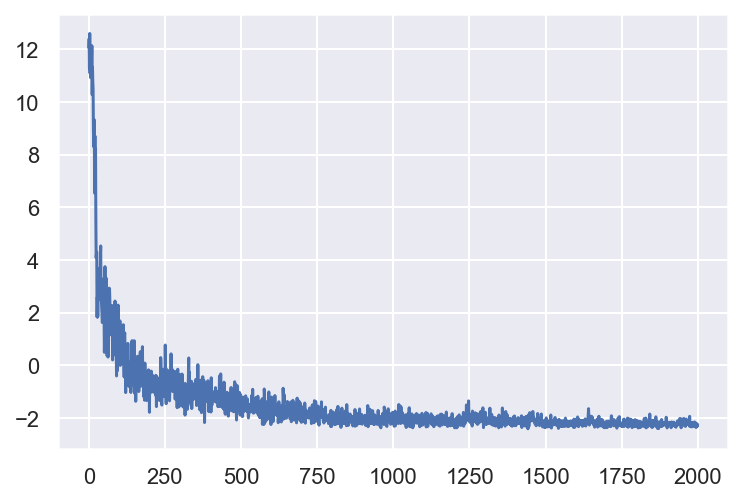

In [13]:
plt.plot(hist_loss);

In [14]:
def scatter_points(points, x_lims=(-7, 7), y_lims=(-7, 7)):

    fig, ax = plt.subplots(figsize=(7, 7))
    ax.scatter(points[:, 0], points[:, 1], alpha=0.7, s=25)
    ax.set_xlim(*x_lims)
    ax.set_ylim(*y_lims)

    plt.show()

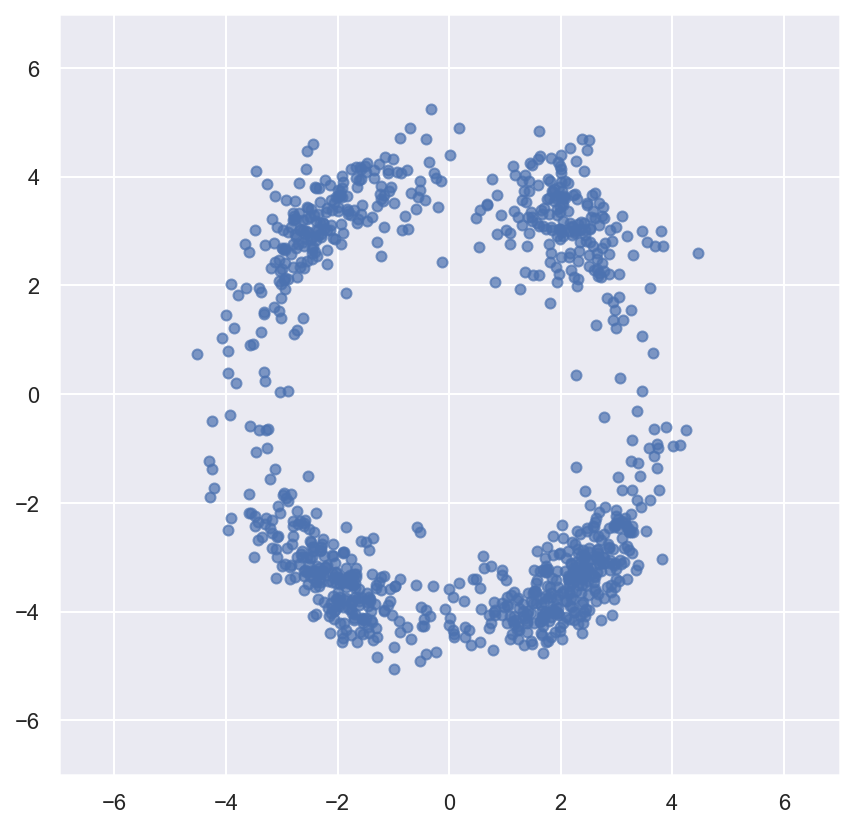

In [15]:
x = flow.prior.sample((1000, ))  
zk, prior_logprob, log_det = flow(x)
scatter_points(zk.data.numpy())

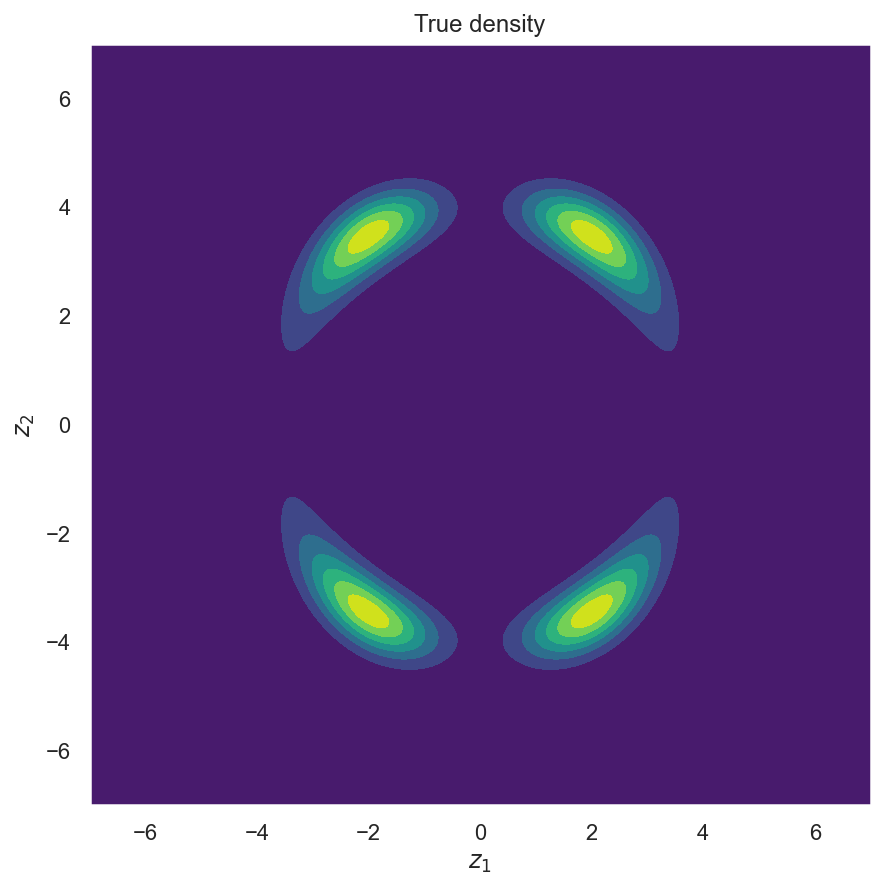

In [16]:
plot_density(p_z)

In [17]:
def show_samples(z0, zk, mu, truth=None, alpha=0.2, x_lims=(-7, 7), y_lims=(-7, 7)):
    
    mask_1 = (z0.data[:, 0] > mu[0]) & (z0.data[:, 1] > mu[1])
    mask_2 = (z0.data[:, 0] > mu[0]) & (z0.data[:, 1] < mu[1])
    mask_3 = (z0.data[:, 0] < mu[0]) & (z0.data[:, 1] > mu[1])
    mask_4 = (z0.data[:, 0] < mu[0]) & (z0.data[:, 1] < mu[1])
    
    fig, axes = plt.subplots(figsize=(16, 8), ncols=2)
    
    for ax, s, title in zip(axes, (z0, zk), ('Base distribution $z_0$', '$z_k$')):
        ax.set_title(title)
        ax.scatter(s[:, 0][mask_1], s[:, 1][mask_1], color='C0', alpha=alpha)
        ax.scatter(s[:, 0][mask_2], s[:, 1][mask_2], color='C1', alpha=alpha)
        ax.scatter(s[:, 0][mask_3], s[:, 1][mask_3], color='C3', alpha=alpha)
        ax.scatter(s[:, 0][mask_4], s[:, 1][mask_4], color='C4', alpha=alpha)
        
        ax.set_xlim(x_lims)
        ax.set_ylim(y_lims)
        
        if truth is not None:
            ax.scatter(truth['mu'], np.log(truth['std']**2), color='black', alpha=1)
        
    plt.show()

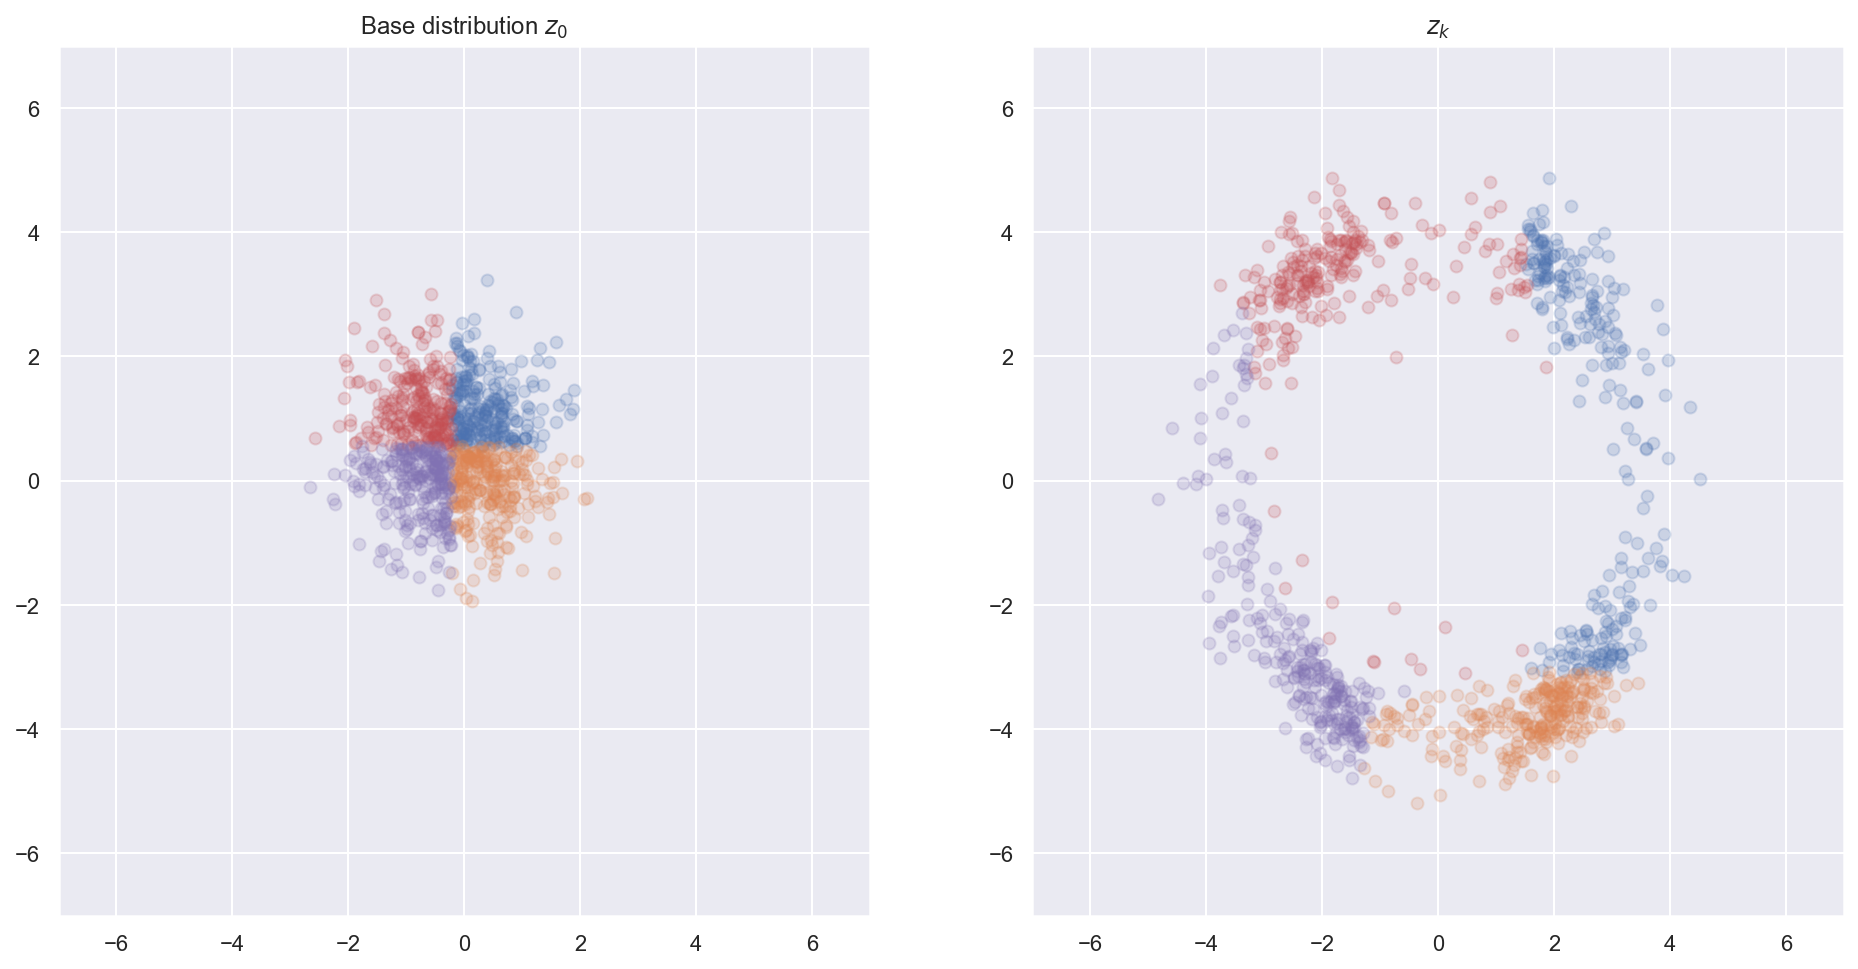

In [18]:
x = flow.prior.sample((1000, ))  
zk, prior_logprob, log_det = flow(x)
show_samples(x.data, zk.data, flow.mu)

# Learn posterior distributions of a [for instance cognitive but here toy] model's parameters

In [19]:
class MyModel: 
    def __init__(self):
        self.dim = 2 # my model is a univariate gaussian
        
    def log_prob(self, theta_samples, observations):
        mu, log_var = theta_samples # Unconstrained space!!!
        sigma = torch.exp(0.5 * log_var)
        return dist.Normal(mu, sigma).log_prob(observations)  # my model is a univariate gaussian

In [20]:
class LossParamDistEstimation:
    """
    Loss function for model's parameters (variational) inference
    """
    
    def __init__(self, model_logprob, observations):
        self.model_logprob = model_logprob
        self.observations = observations.unsqueeze(-1)
        
    def __call__(self, model, batch_size):
        
        x = model.prior.sample((batch_size, ))
        zk, prior_logprob, log_det = model(x)

        ln_q0 = prior_logprob.sum()
        sum_of_log_jacobians = log_det.sum()
        
        theta_samples = zk.T
        ll = self.model_logprob(theta_samples=theta_samples, observations=self.observations).sum()

        return (ln_q0 - sum_of_log_jacobians - ll) / batch_size

In [21]:
true_mu = 4
true_sigma = 2 
n = 100
torch.manual_seed(1234)
observations = dist.Normal(loc=true_mu, scale=true_sigma).sample((n, ))

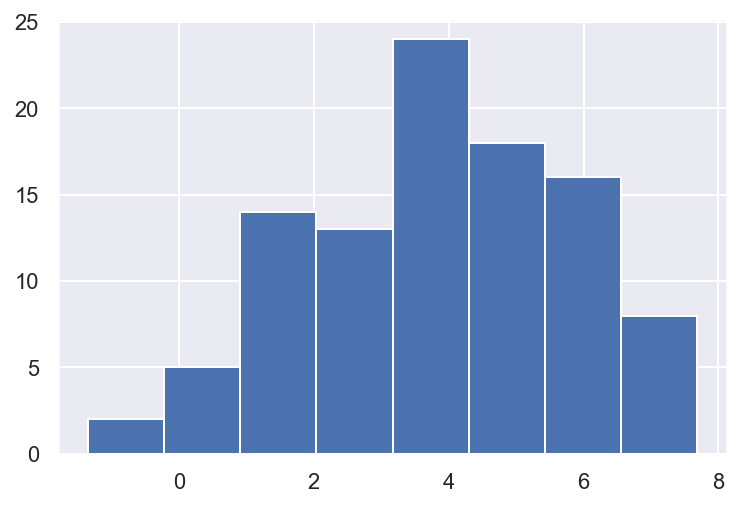

In [22]:
plt.hist(x=observations.data.numpy(), bins="auto");

In [23]:
my_model = MyModel()
loss_func = LossParamDistEstimation(model_logprob=my_model.log_prob, observations=observations)

In [24]:
flow, hist_loss = train(loss_func=loss_func, dim=my_model.dim)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [25]:
with torch.no_grad():
    x = flow.prior.sample((1000, ))  
    zk, prior_logprob, log_det = flow(x)
mu_samples, log_var_samples = zk.T
sigma_samples = torch.exp(0.5*log_var_samples)
true_log_var = np.log(true_sigma**2)

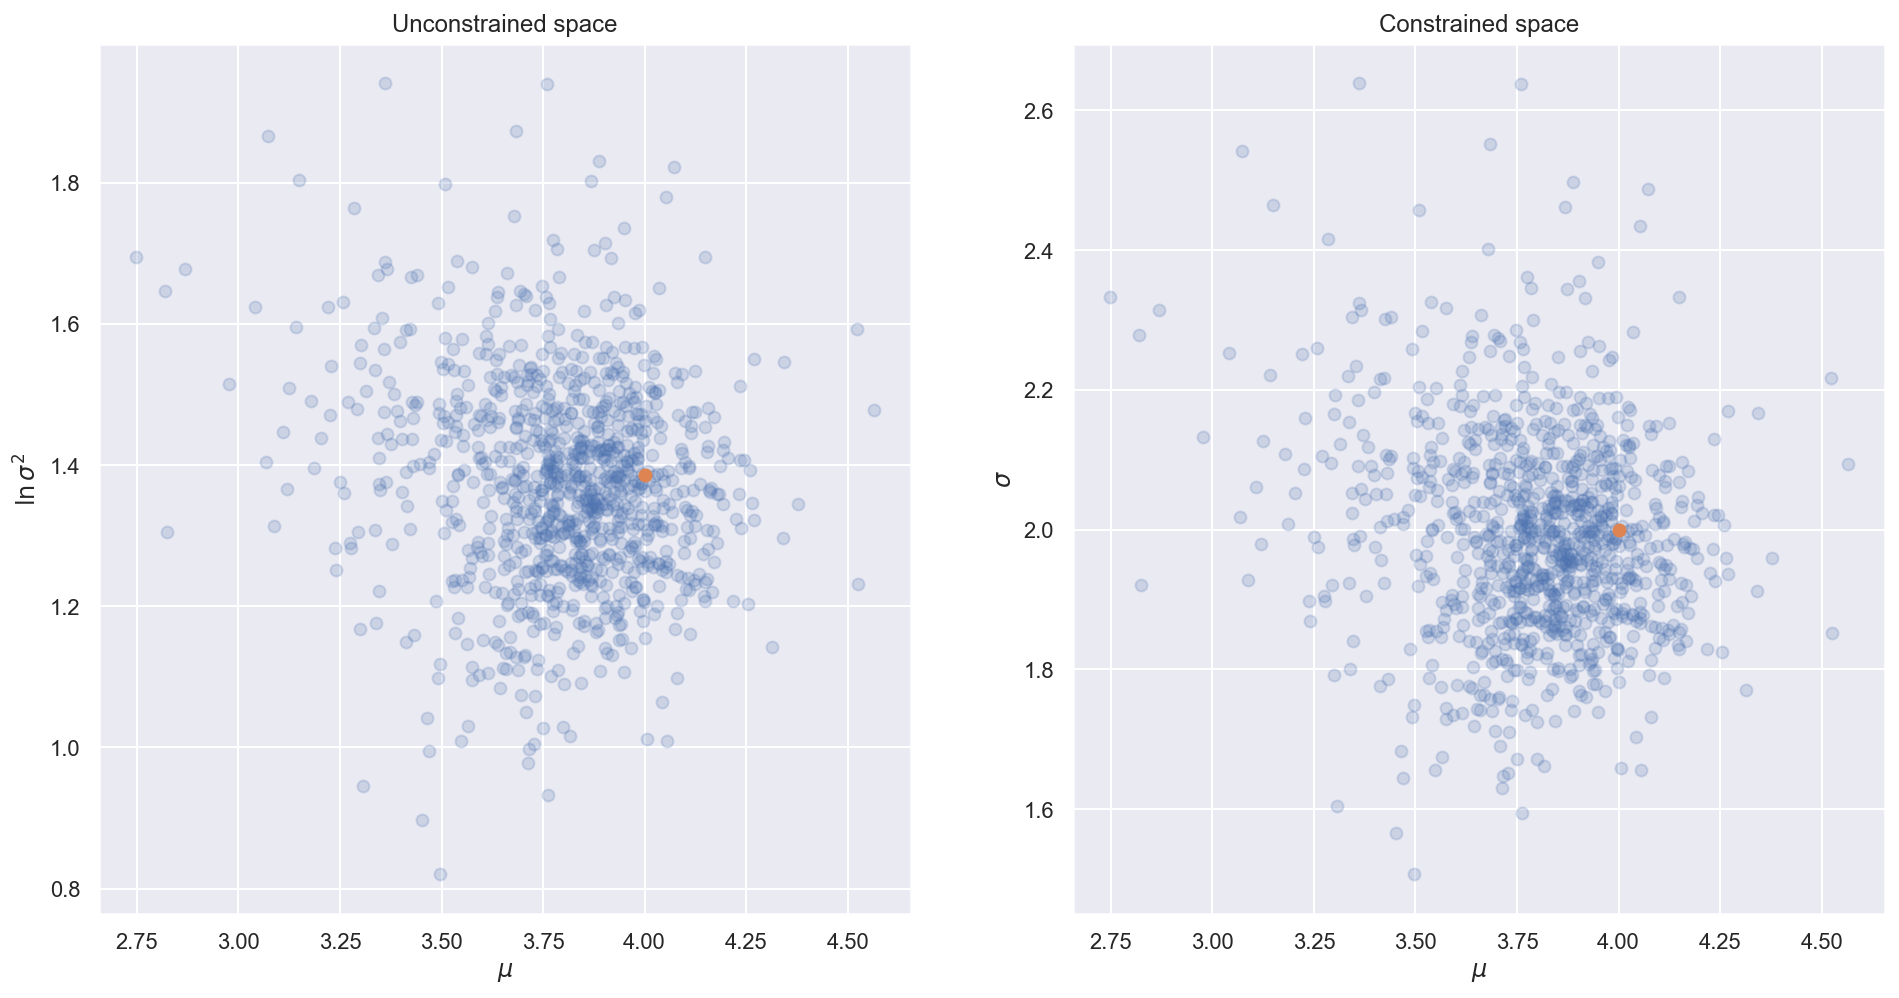

In [26]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 8))
alpha=0.2

ax=axes[0]
ax.set_title("Unconstrained space")
ax.scatter(mu_samples, log_var_samples, alpha=alpha)
ax.scatter(true_mu, true_log_var)
ax.set_xlabel("$\mu$")
ax.set_ylabel("$\ln \sigma^2$");

ax=axes[1]
ax.set_title("Constrained space")
ax.scatter(mu_samples, sigma_samples, alpha=alpha)
ax.scatter(true_mu, true_sigma)
ax.set_xlabel("$\mu$")
ax.set_ylabel("$\sigma$");

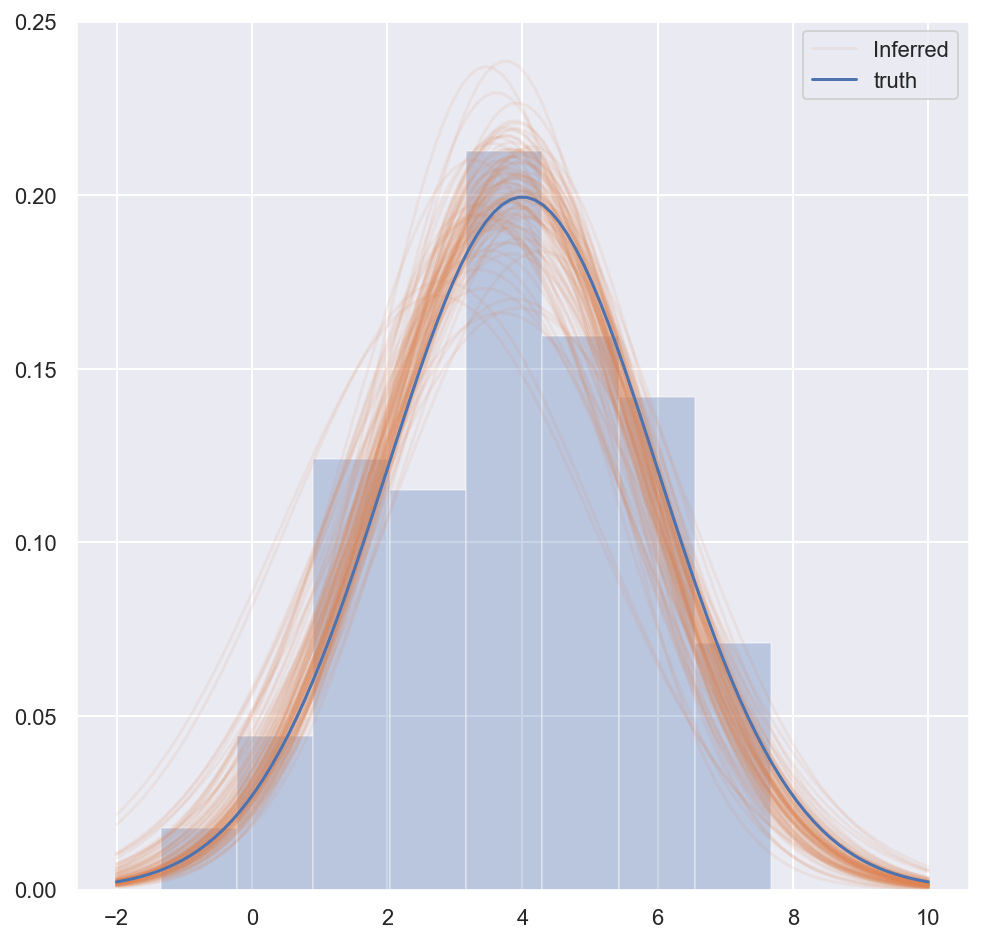

In [27]:
x = torch.linspace(-2, 10, 100)
true_theta = torch.tensor([true_mu, true_log_var])
pdf_true = my_model.log_prob(true_theta, x.reshape(-1, 1)).exp()
pdf_sample = my_model.log_prob(zk[:100].T, x.reshape(-1, 1)).exp()

fig, ax = plt.subplots(figsize=(8, 8))
ax.hist(observations.data.numpy(), bins='auto', alpha=0.3, density=True)
ax.plot(x, pdf_sample, color="C1", alpha=0.1, label='Inferred')
ax.plot(x, pdf_true, color='C0', label="truth")

handles, labels = ax.get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
ax.legend(handles, labels,);

# Learning distribution from raw data 

In [28]:
# From https://github.com/tonyduan/normalizing-flows
DEFAULT_MIN_BIN_WIDTH = 1e-3
DEFAULT_MIN_BIN_HEIGHT = 1e-3
DEFAULT_MIN_DERIVATIVE = 1e-3

def searchsorted(bin_locations, inputs, eps=1e-6):
    bin_locations[..., -1] += eps
    return torch.sum(
        inputs[..., None] >= bin_locations,
        dim=-1
    ) - 1
        
# supported non-linearities: note that the function must be invertible
functional_derivatives = {
    torch.tanh: lambda x: 1 - torch.pow(torch.tanh(x), 2),
    F.leaky_relu: lambda x: (x > 0).type(torch.FloatTensor) + \
                            (x < 0).type(torch.FloatTensor) * -0.01,
    F.elu: lambda x: (x > 0).type(torch.FloatTensor) + \
                     (x < 0).type(torch.FloatTensor) * torch.exp(x)
}

def unconstrained_RQS(inputs, unnormalized_widths, unnormalized_heights,
                      unnormalized_derivatives, inverse=False,
                      tail_bound=1., min_bin_width=DEFAULT_MIN_BIN_WIDTH,
                      min_bin_height=DEFAULT_MIN_BIN_HEIGHT,
                      min_derivative=DEFAULT_MIN_DERIVATIVE):
    inside_intvl_mask = (inputs >= -tail_bound) & (inputs <= tail_bound)
    outside_interval_mask = ~inside_intvl_mask

    outputs = torch.zeros_like(inputs)
    logabsdet = torch.zeros_like(inputs)

    unnormalized_derivatives = F.pad(unnormalized_derivatives, pad=(1, 1))
    constant = np.log(np.exp(1 - min_derivative) - 1)
    unnormalized_derivatives[..., 0] = constant
    unnormalized_derivatives[..., -1] = constant

    outputs[outside_interval_mask] = inputs[outside_interval_mask]
    logabsdet[outside_interval_mask] = 0

    outputs[inside_intvl_mask], logabsdet[inside_intvl_mask] = RQS(
        inputs=inputs[inside_intvl_mask],
        unnormalized_widths=unnormalized_widths[inside_intvl_mask, :],
        unnormalized_heights=unnormalized_heights[inside_intvl_mask, :],
        unnormalized_derivatives=unnormalized_derivatives[inside_intvl_mask, :],
        inverse=inverse,
        left=-tail_bound, right=tail_bound, bottom=-tail_bound, top=tail_bound,
        min_bin_width=min_bin_width,
        min_bin_height=min_bin_height,
        min_derivative=min_derivative
    )
    return outputs, logabsdet

def RQS(inputs, unnormalized_widths, unnormalized_heights,
        unnormalized_derivatives, inverse=False, left=0., right=1.,
        bottom=0., top=1., min_bin_width=DEFAULT_MIN_BIN_WIDTH,
        min_bin_height=DEFAULT_MIN_BIN_HEIGHT,
        min_derivative=DEFAULT_MIN_DERIVATIVE):
    if torch.min(inputs) < left or torch.max(inputs) > right:
        raise ValueError("Input outside domain")

    num_bins = unnormalized_widths.shape[-1]

    if min_bin_width * num_bins > 1.0:
        raise ValueError('Minimal bin width too large for the number of bins')
    if min_bin_height * num_bins > 1.0:
        raise ValueError('Minimal bin height too large for the number of bins')

    widths = F.softmax(unnormalized_widths, dim=-1)
    widths = min_bin_width + (1 - min_bin_width * num_bins) * widths
    cumwidths = torch.cumsum(widths, dim=-1)
    cumwidths = F.pad(cumwidths, pad=(1, 0), mode='constant', value=0.0)
    cumwidths = (right - left) * cumwidths + left
    cumwidths[..., 0] = left
    cumwidths[..., -1] = right
    widths = cumwidths[..., 1:] - cumwidths[..., :-1]

    derivatives = min_derivative + F.softplus(unnormalized_derivatives)

    heights = F.softmax(unnormalized_heights, dim=-1)
    heights = min_bin_height + (1 - min_bin_height * num_bins) * heights
    cumheights = torch.cumsum(heights, dim=-1)
    cumheights = F.pad(cumheights, pad=(1, 0), mode='constant', value=0.0)
    cumheights = (top - bottom) * cumheights + bottom
    cumheights[..., 0] = bottom
    cumheights[..., -1] = top
    heights = cumheights[..., 1:] - cumheights[..., :-1]

    if inverse:
        bin_idx = searchsorted(cumheights, inputs)[..., None]
    else:
        bin_idx = searchsorted(cumwidths, inputs)[..., None]

    input_cumwidths = cumwidths.gather(-1, bin_idx)[..., 0]
    input_bin_widths = widths.gather(-1, bin_idx)[..., 0]

    input_cumheights = cumheights.gather(-1, bin_idx)[..., 0]
    delta = heights / widths
    input_delta = delta.gather(-1, bin_idx)[..., 0]

    input_derivatives = derivatives.gather(-1, bin_idx)[..., 0]
    input_derivatives_plus_one = derivatives[..., 1:].gather(-1, bin_idx)
    input_derivatives_plus_one = input_derivatives_plus_one[..., 0]

    input_heights = heights.gather(-1, bin_idx)[..., 0]

    if inverse:
        a = (((inputs - input_cumheights) * (input_derivatives \
            + input_derivatives_plus_one - 2 * input_delta) \
            + input_heights * (input_delta - input_derivatives)))
        b = (input_heights * input_derivatives - (inputs - input_cumheights) \
            * (input_derivatives + input_derivatives_plus_one \
            - 2 * input_delta))
        c = - input_delta * (inputs - input_cumheights)

        discriminant = b.pow(2) - 4 * a * c
        assert (discriminant >= 0).all()

        root = (2 * c) / (-b - torch.sqrt(discriminant))
        outputs = root * input_bin_widths + input_cumwidths

        theta_one_minus_theta = root * (1 - root)
        denominator = input_delta \
                      + ((input_derivatives + input_derivatives_plus_one \
                      - 2 * input_delta) * theta_one_minus_theta)
        derivative_numerator = input_delta.pow(2) \
                               * (input_derivatives_plus_one * root.pow(2) \
                                + 2 * input_delta * theta_one_minus_theta \
                                + input_derivatives * (1 - root).pow(2))
        logabsdet = torch.log(derivative_numerator) - 2 * torch.log(denominator)
        return outputs, -logabsdet
    else:
        theta = (inputs - input_cumwidths) / input_bin_widths
        theta_one_minus_theta = theta * (1 - theta)

        numerator = input_heights * (input_delta * theta.pow(2) \
                    + input_derivatives * theta_one_minus_theta)
        denominator = input_delta + ((input_derivatives \
                      + input_derivatives_plus_one - 2 * input_delta) \
                      * theta_one_minus_theta)
        outputs = input_cumheights + numerator / denominator

        derivative_numerator = input_delta.pow(2) \
                               * (input_derivatives_plus_one * theta.pow(2) \
                                + 2 * input_delta * theta_one_minus_theta \
                                + input_derivatives * (1 - theta).pow(2))
        logabsdet = torch.log(derivative_numerator) - 2 * torch.log(denominator)
        return outputs, logabsdet

In [50]:
class NSF_CL_BasedNormalizingFlow(nn.Module):
    
    """
    Adpated from https://github.com/tonyduan/normalizing-flows
    """

    def __init__(self, dim, flow_length):
        super().__init__()
        self.flows = nn.ModuleList([NSF_CL(dim=dim) for _ in range(flow_length)])
    
        self.mu = nn.Parameter(torch.zeros(dim).uniform_(-0.01, 0.01))
        self.log_var = nn.Parameter(torch.zeros(dim).uniform_(-0.01, 0.01))
        
        self.dim = dim
    
    @property
    def prior(self):
        covar = torch.zeros((self.dim, self.dim))
        mask_diag = torch.eye(self.dim, dtype=bool)
        covar[mask_diag] = torch.exp(0.5*self.log_var)
        return dist.MultivariateNormal(self.mu, covar)

    def forward(self, x):
        m, _ = x.shape
        log_det = torch.zeros(m)
        for flow in self.flows:
            x, ld = flow.forward(x)
            log_det += ld
        z, prior_logprob = x, self.prior.log_prob(x)
        return z, prior_logprob, log_det

    def inverse(self, z):
        m, _ = z.shape
        log_det = torch.zeros(m)
        for flow in self.flows[::-1]:
            z, ld = flow.inverse(z)
            log_det += ld
        x = z
        return x, log_det

    def sample(self, n_samples):
        z = self.prior.sample((n_samples,))
        x, _ = self.inverse(z)
        return x
        
        

class FCNN(nn.Module):
    """
    Useful for NSF_CL
    From https://github.com/tonyduan/normalizing-flows
    Simple fully connected neural network.
    """
    def __init__(self, in_dim, out_dim, hidden_dim):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, out_dim),
        )

    def forward(self, x):
        return self.network(x)


class NSF_CL(nn.Module):
    """
    From https://github.com/tonyduan/normalizing-flows
    Neural spline flow, coupling layer.

    [Durkan et al. 2019]
    """
    def __init__(self, dim, K=5, B=3, hidden_dim=8, base_network=FCNN):
        super().__init__()
        self.dim = dim
        self.K = K
        self.B = B
        self.f1 = base_network(dim // 2, (3 * K - 1) * dim // 2, hidden_dim)
        self.f2 = base_network(dim // 2, (3 * K - 1) * dim // 2, hidden_dim)

    def forward(self, x):
        log_det = torch.zeros(x.shape[0])
        lower, upper = x[:, :self.dim // 2], x[:, self.dim // 2:]
        out = self.f1(lower).reshape(-1, self.dim // 2, 3 * self.K - 1)
        W, H, D = torch.split(out, self.K, dim = 2)
        W, H = torch.softmax(W, dim = 2), torch.softmax(H, dim = 2)
        W, H = 2 * self.B * W, 2 * self.B * H
        D = F.softplus(D)
        upper, ld = unconstrained_RQS(
            upper, W, H, D, inverse=False, tail_bound=self.B)
        log_det += torch.sum(ld, dim = 1)
        out = self.f2(upper).reshape(-1, self.dim // 2, 3 * self.K - 1)
        W, H, D = torch.split(out, self.K, dim = 2)
        W, H = torch.softmax(W, dim = 2), torch.softmax(H, dim = 2)
        W, H = 2 * self.B * W, 2 * self.B * H
        D = F.softplus(D)
        lower, ld = unconstrained_RQS(
            lower, W, H, D, inverse=False, tail_bound=self.B)
        log_det += torch.sum(ld, dim = 1)
        return torch.cat([lower, upper], dim = 1), log_det

    def inverse(self, z):
        log_det = torch.zeros(z.shape[0])
        lower, upper = z[:, :self.dim // 2], z[:, self.dim // 2:]
        out = self.f2(upper).reshape(-1, self.dim // 2, 3 * self.K - 1)
        W, H, D = torch.split(out, self.K, dim = 2)
        W, H = torch.softmax(W, dim = 2), torch.softmax(H, dim = 2)
        W, H = 2 * self.B * W, 2 * self.B * H
        D = F.softplus(D)
        lower, ld = unconstrained_RQS(
            lower, W, H, D, inverse=True, tail_bound=self.B)
        log_det += torch.sum(ld, dim = 1)
        out = self.f1(lower).reshape(-1, self.dim // 2, 3 * self.K - 1)
        W, H, D = torch.split(out, self.K, dim = 2)
        W, H = torch.softmax(W, dim = 2), torch.softmax(H, dim = 2)
        W, H = 2 * self.B * W, 2 * self.B * H
        D = F.softplus(D)
        upper, ld = unconstrained_RQS(
            upper, W, H, D, inverse = True, tail_bound = self.B)
        log_det += torch.sum(ld, dim = 1)
        return torch.cat([lower, upper], dim = 1), log_det


In [51]:
def gen_data(n=512):
    return np.r_[np.random.randn(n // 3, 2) + np.array([0, 6]),
                 np.random.randn(n // 3, 2) + np.array([2.5, 3]),
                 np.random.randn(n // 3, 2) + np.array([-2.5, 3])]

In [52]:
class LossRawData:
    
    def __init__(self, observations):
        self.observations = observations #.unsqueeze(-1)
    
    def __call__(self, model):
        
        zk, prior_logprob, log_det = model(self.observations)
        return - torch.mean(prior_logprob + log_det)

In [53]:
def train(loss_func, dim=2, flow_length=16, epochs=1000, batch_size=40, lr=0.01, seed=123):
    
    torch.manual_seed(seed)
    
    # prior = dist.MultivariateNormal(torch.zeros(2), torch.eye(2))
    # flows = [NSF_CL(dim=2) for _ in range(16)]
    # model = NormalizingFlowModel(prior, flows)
    model = NSF_CL_BasedNormalizingFlow(dim=dim, flow_length=flow_length)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    hist_loss = np.zeros(epochs)
    
    with tqdm(total=epochs) as pbar:
        
        for i in range(epochs):
            
            optimizer.zero_grad()
            
            loss = loss_func(model=model)
            
            loss.backward()
            optimizer.step()
            
            hist_loss[i] = loss.item()
            
            if i % 50 == 0 and i > 0:
                pbar.set_postfix({'loss': np.mean(hist_loss[i-50:i])})

            pbar.update()
            
    return model, hist_loss

In [73]:
observations = torch.from_numpy(gen_data().astype(np.float32))

In [84]:
def plot_data(ax, x, x_lim=None, y_lim=None, *args, **kwargs):
    ax.scatter(x[:,0], x[:,1], alpha=0.5, *args, **kwargs)
    if x_lim is not None:
        ax.set_xlim(*x_lim)
    if y_lim is not None:
        ax.set_ylim(*y_lim)

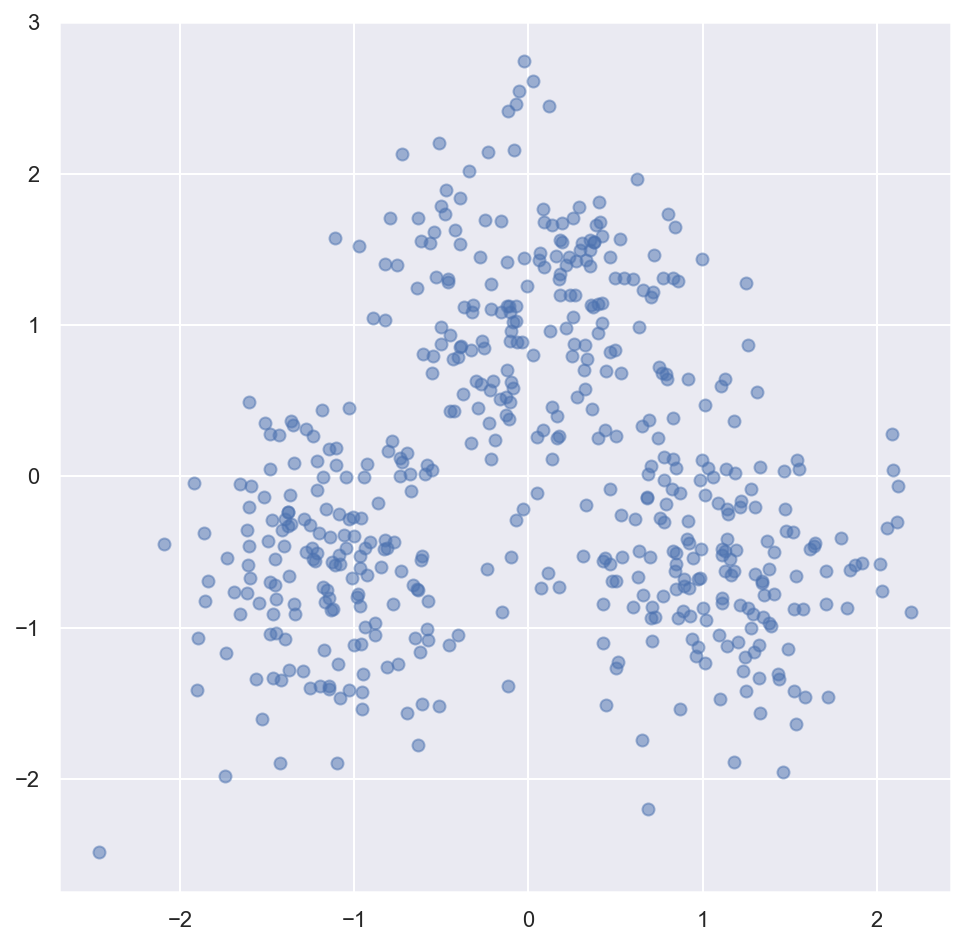

In [85]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_data(ax=ax, x=observations.data)

In [78]:
def rescale(x):
    for i in range(x.shape[1]):
        x[:,i] = (x[:,i] - torch.mean(x[:,i])) / torch.std(x[:,i])
    return x

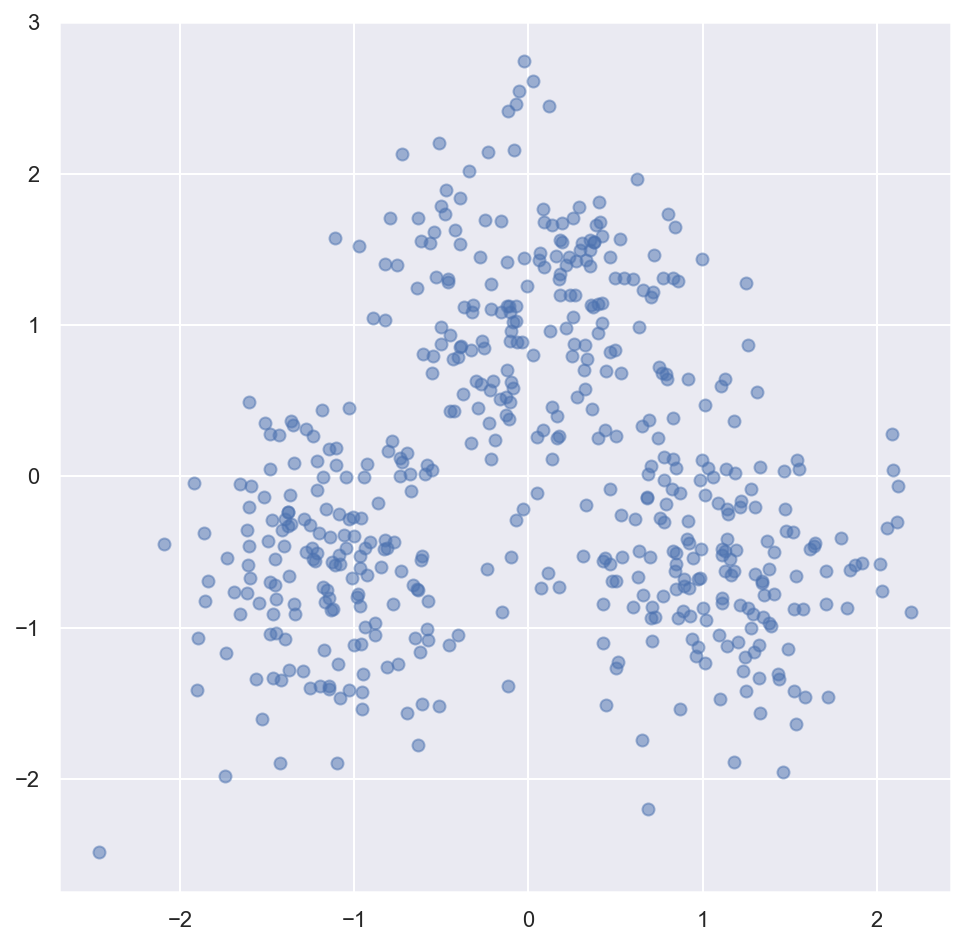

In [79]:
observations = rescale(observations)

fig, ax = plt.subplots(figsize=(8, 8))
plot_data(ax=ax, x=observations.data)

In [80]:
loss_func = LossRawData(observations)

In [81]:
model, hist_loss = train(loss_func=loss_func, lr=0.005)

  0%|          | 0/1000 [00:00<?, ?it/s]

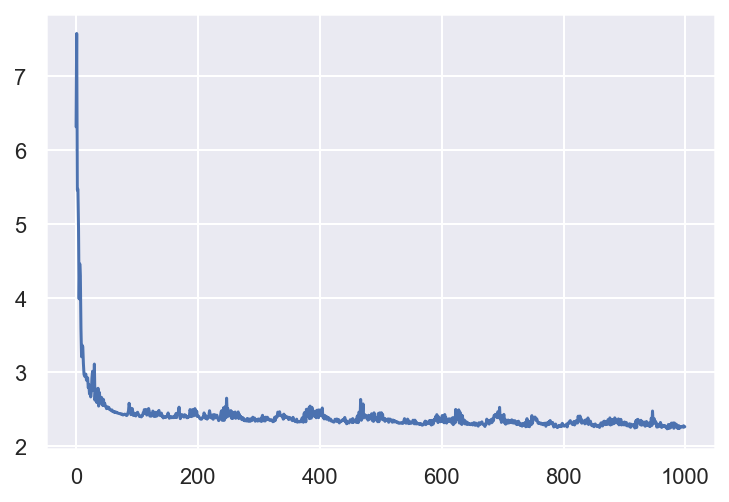

In [82]:
plt.plot(hist_loss)

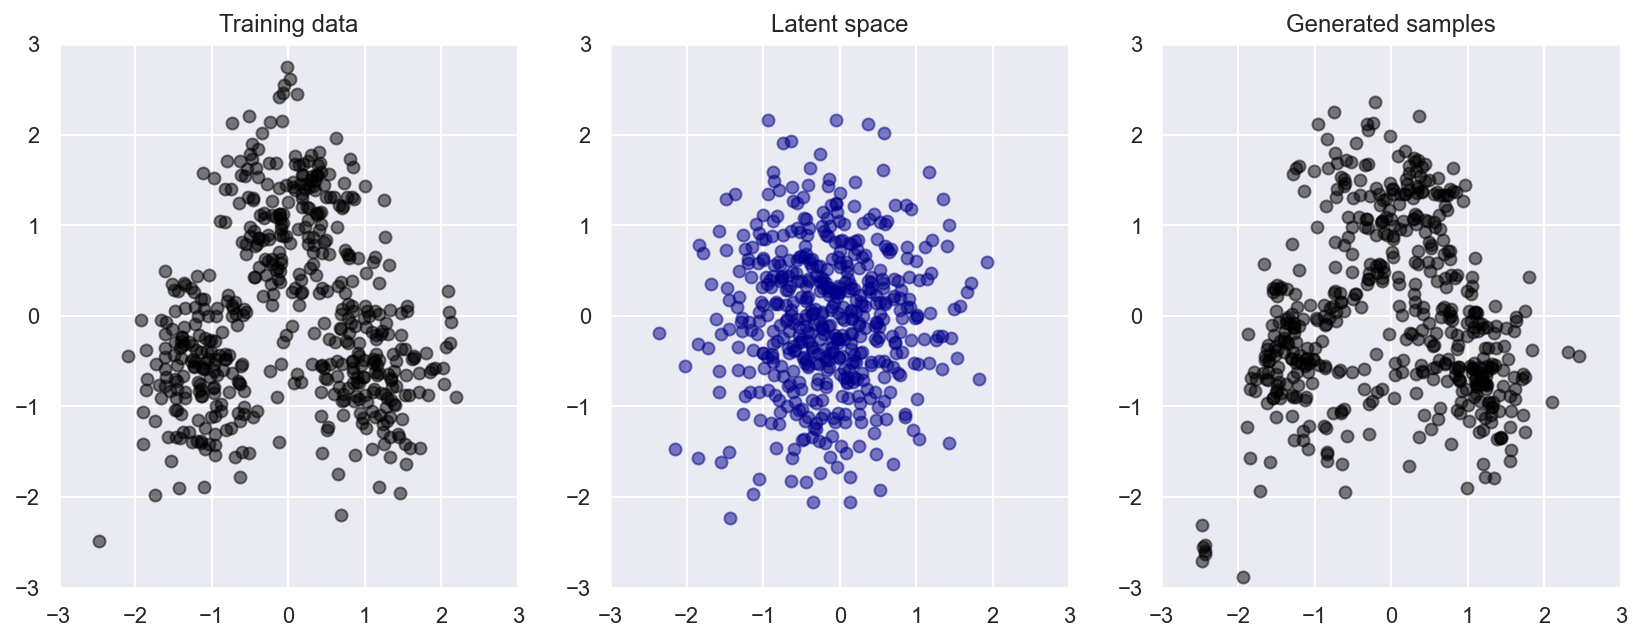

In [92]:
fig, axes = plt.subplots(figsize=(14, 5), ncols=3)

ax = axes[0]
plot_data(ax=ax, x=observations, color="black", x_lim=(-3, 3), y_lim=(-3, 3))
ax.set_title("Training data")

ax = axes[1]
with torch.no_grad():
    zk, prior_logprob, log_det = model(observations)
plot_data(ax=ax, x=zk.data, color="darkblue", x_lim=(-3, 3), y_lim=(-3, 3), )
ax.set_title("Latent space")

ax = axes[2]
samples = model.sample(500).data
plot_data(ax=ax, x=samples, color="black", x_lim=(-3, 3), y_lim=(-3, 3),)
ax.set_title("Generated samples");

# Credits

Front picture from https://siboehm.com/articles/19/normalizing-flow-network

# References

## Blogs

https://medium.com/swlh/normalizing-flows-are-not-magic-22752d0c924
https://siboehm.com/articles/19/normalizing-flow-network
https://blog.evjang.com/2018/01/nf1.html

## Github

https://github.com/ex4sperans/variational-inference-with-normalizing-flows
https://github.com/tonyduan/normalizing-flows


## Documentation

https://pyro.ai/examples/normalizing_flows_i.html


## Papers

Danilo Jimenez Rezende, Shakir Mohamed. [*Variational Inference with Normalizing Flows*](http://proceedings.mlr.press/v37/rezende15.pdf). ICML 2015.

Ivan Kobyzev, Simon J.D. Prince, and Marcus A. Brubaker. [*Normalizing Flows: An Introduction and Review of Current Methods*](https://arxiv.org/abs/1908.09257). \[arXiv:1908.09257\] 2019.

George Papamakarios, Eric Nalisnick, Danilo Jimenez Rezende, Shakir Mohamed, Balaji Lakshminarayanan. [*Normalizing Flows for Probabilistic Modeling and Inference*](https://arxiv.org/abs/1912.02762). \[arXiv:1912.02762\] 2019.

Conor Durkan, Artur Bekasov, Iain Murray, George Papamakarios. [*Neural Spline Flows*](https://arxiv.org/abs/1906.04032). NeurIPS 2019.